# Porto Seguro's Safe Driver Prediction    
**1. 문제정의**  
**2. 데이터 불러오기 및 탐색**  
**3. 데이터 품질 검사**  
**4. 데이터 시각화**  
**5. 피처엔지니어링**  
**6. 모델링**

# 1. 문제정의  

**대회설명**
- 브라질 보험사 Porto Seguro에서 주최한 캐글 대회: 차년도에 보험클레임을 걸 확률 값을 예측
- 평가 기준: Normalized Gini Coefficient

**컬럼설명**
- 유사한 피처들은 같은 태그를 가지고 있음(예: ind, reg, car, calc) 등 비식별 데이터  
- 피처 이름 뒤에 bin은 binary 피처를 의미하고, cat은 category 피처를 의미  
- 피처 이름에 아무런 접미사가 없는 것은 연속되는 수이거나 서수  
- 값이 -1이면 관찰에서 누락된 것을 의미  
- 타겟 컬럼은 해당 보험 계약자에 대한 청구가 제기되었는지의 여부  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# 2. 데이터 불러오기 및 탐색

**2-1. 데이터 불러오기**

In [2]:
debug = False
if debug:
    NROWS = 10000
else:
    NROWS = None

train = pd.read_csv('./train.csv', nrows = NROWS)
test = pd.read_csv('./test.csv', nrows = NROWS)

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


In [5]:
train.nunique()

id                595212
target                 2
ps_ind_01              8
ps_ind_02_cat          5
ps_ind_03             12
ps_ind_04_cat          3
ps_ind_05_cat          8
ps_ind_06_bin          2
ps_ind_07_bin          2
ps_ind_08_bin          2
ps_ind_09_bin          2
ps_ind_10_bin          2
ps_ind_11_bin          2
ps_ind_12_bin          2
ps_ind_13_bin          2
ps_ind_14              5
ps_ind_15             14
ps_ind_16_bin          2
ps_ind_17_bin          2
ps_ind_18_bin          2
ps_reg_01             10
ps_reg_02             19
ps_reg_03           5013
ps_car_01_cat         13
ps_car_02_cat          3
ps_car_03_cat          3
ps_car_04_cat         10
ps_car_05_cat          3
ps_car_06_cat         18
ps_car_07_cat          3
ps_car_08_cat          2
ps_car_09_cat          6
ps_car_10_cat          3
ps_car_11_cat        104
ps_car_11              5
ps_car_12            184
ps_car_13          70482
ps_car_14            850
ps_car_15             15
ps_calc_01            10


In [6]:
print("Train set shape: ", train.shape)
print("Test set shape: ", test.shape)

Train set shape:  (595212, 59)
Test set shape:  (892816, 58)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

**2-2.	변수 정리하기(메타 데이터) -> Meta 데이터프레임 생성(인덱스는 변수명) 양식**  
•	role: input, target  
•	level: nominal, interval, ordinal, binary  
•	keep: True or False -> 데이터 전처리 중 제거하는 변수는 False로 변경(id는 기본 False)  
•	dtype: int, float, str  

In [6]:
data = []
for f in train.columns:
    # role 정의
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # level 정의
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == 'int64':
        level = 'ordinal'
    elif train[f].dtype == float:
        level = 'interval'
        
    # id를 제외한 모든 변수를 True로 초기화
    keep = True
    if f == 'id':
        keep = False
    
    # 데이터 유형 정의
    dtype = train[f].dtype
    
    # 변수에 대한 메타 데이터를 담는 사전 만들기
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [9]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [10]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [11]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


**2-3.	Porto 데이터셋의 열에 대한 요약 통계 및 결측치 확인**

In [12]:
train.describe(include = "all")

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.0000

In [14]:
print(pd.isnull(train).sum())

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


In [58]:
print(pd.isnull(test).sum())

id                           0
ps_ind_01                    0
ps_ind_03                    0
ps_ind_06_bin                0
ps_ind_07_bin                0
                         ...  
ps_car_14 ps_calc_03    297604
ps_car_15^2             297604
ps_car_15 ps_calc_01    297604
ps_car_15 ps_calc_02    297604
ps_car_15 ps_calc_03    297604
Length: 143, dtype: int64


**2-4.	Meta를 이용하여  nominal을 제외한 나머지 변수 각각 기술통계(describe)**

In [15]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [16]:
v = meta[(meta.level == "ordinal") & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [17]:
v = meta[(meta.level == "binary") & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**2-5.	Target 값 분포 시각화**

In [18]:
targets = train.target.values

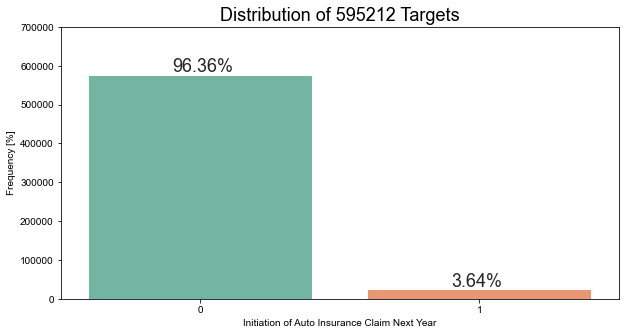

In [19]:
ax = sns.countplot(x = targets ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

# 3. 데이터 품질 검사

**3-1. 결측치 확인 및 처리하기**

In [20]:
vars_with_missing = []

for f in train.columns:
  missings = train[train[f] == -1][f].count()
  if missings > 0:
    vars_with_missing.append(f)
    missings_perc = missings / train.shape[0]
    
    print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))   

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


In [21]:
avars_with_missing = []

for f in test.columns:
  missings = test[test[f] == -1][f].count()
  if missings > 0:
    avars_with_missing.append(f)
    missings_perc = missings / test.shape[0]
    
    print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
print('In total, there are {} variables with missing values'.format(len(avars_with_missing)))   

Variable ps_ind_02_cat has 307 records (0.03%) with missing values
Variable ps_ind_04_cat has 145 records (0.02%) with missing values
Variable ps_ind_05_cat has 8710 records (0.98%) with missing values
Variable ps_reg_03 has 161684 records (18.11%) with missing values
Variable ps_car_01_cat has 160 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 616911 records (69.10%) with missing values
Variable ps_car_05_cat has 400359 records (44.84%) with missing values
Variable ps_car_07_cat has 17331 records (1.94%) with missing values
Variable ps_car_09_cat has 877 records (0.10%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 63805 records (7.15%) with missing values
In total, there are 12 variables with missing values


In [7]:
# 평균 또는 모드로 대체하기
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

In [8]:
test['ps_reg_03'] = mean_imp.fit_transform(test[['ps_reg_03']]).ravel()
test['ps_car_12'] = mean_imp.fit_transform(test[['ps_car_12']]).ravel()
test['ps_car_14'] = mean_imp.fit_transform(test[['ps_car_14']]).ravel()
test['ps_car_11'] = mode_imp.fit_transform(test[['ps_car_11']]).ravel()

In [9]:
# 누락 된 값이 너무 많은 변수는 제거
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
test.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False  # 메타 데이터 갱신

In [10]:
#범주형 변수 unique값 개수
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


**3-2. ps_car_11_cat 변수 스무딩**

In [11]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):

    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # 타겟 평균을 계산
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # 스무딩 계산
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # 모든 타겟 데이터에 평균 적용하기
    prior = target.mean()
    # 카운트가 클수록 full_avg가 적어집니다.
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # 학습, 테스트 데이터에 평균 적용
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지하지 않으므로 복원합니다.
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지하지 않으므로 복원합니다.
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [12]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# 4. 데이터 시각화

**4-1. target 비율보기**

<Figure size 432x288 with 0 Axes>

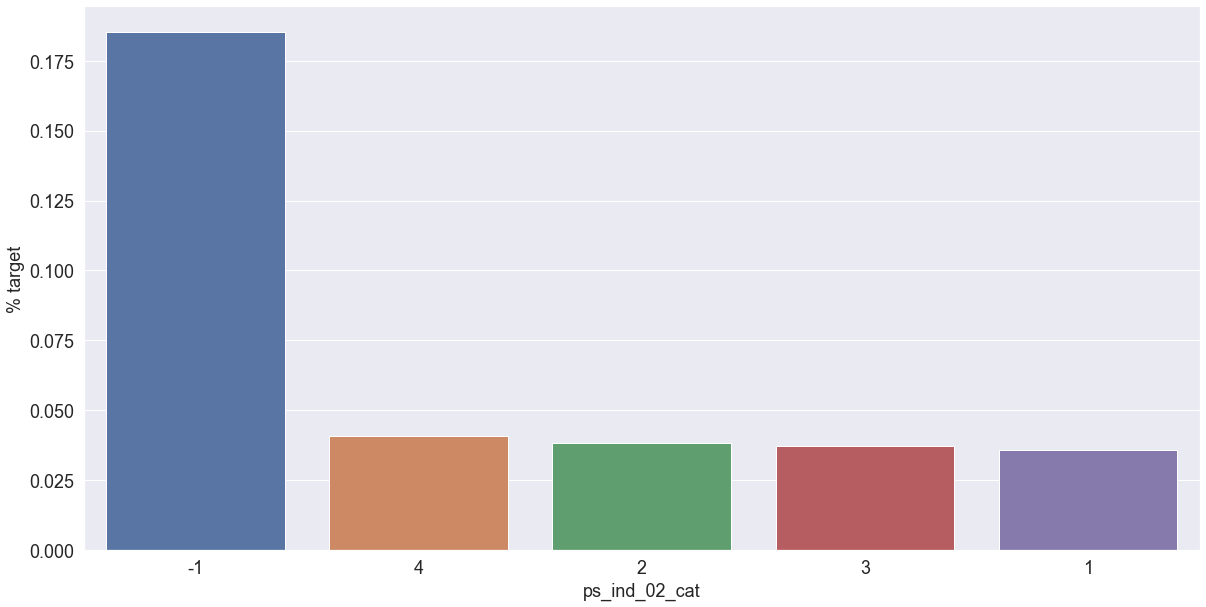

<Figure size 432x288 with 0 Axes>

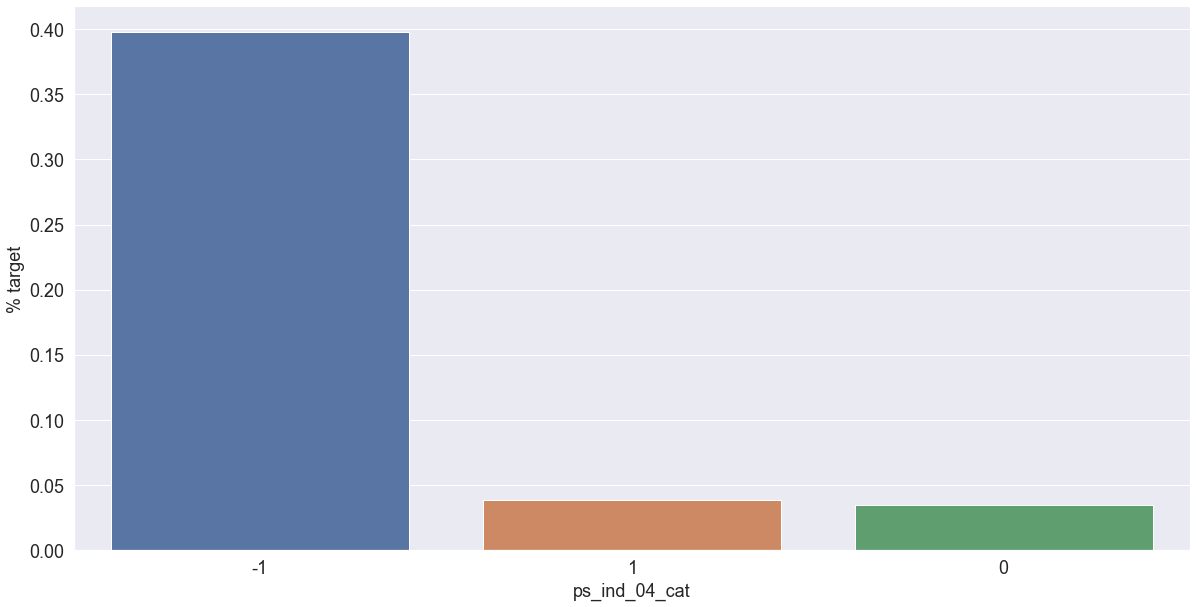

<Figure size 432x288 with 0 Axes>

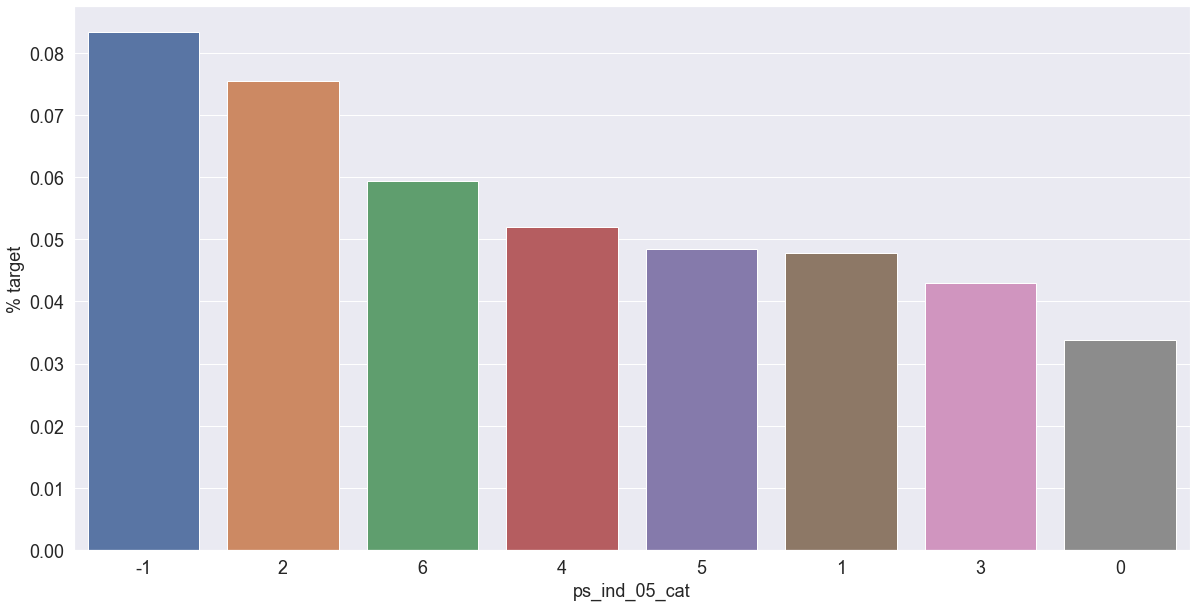

<Figure size 432x288 with 0 Axes>

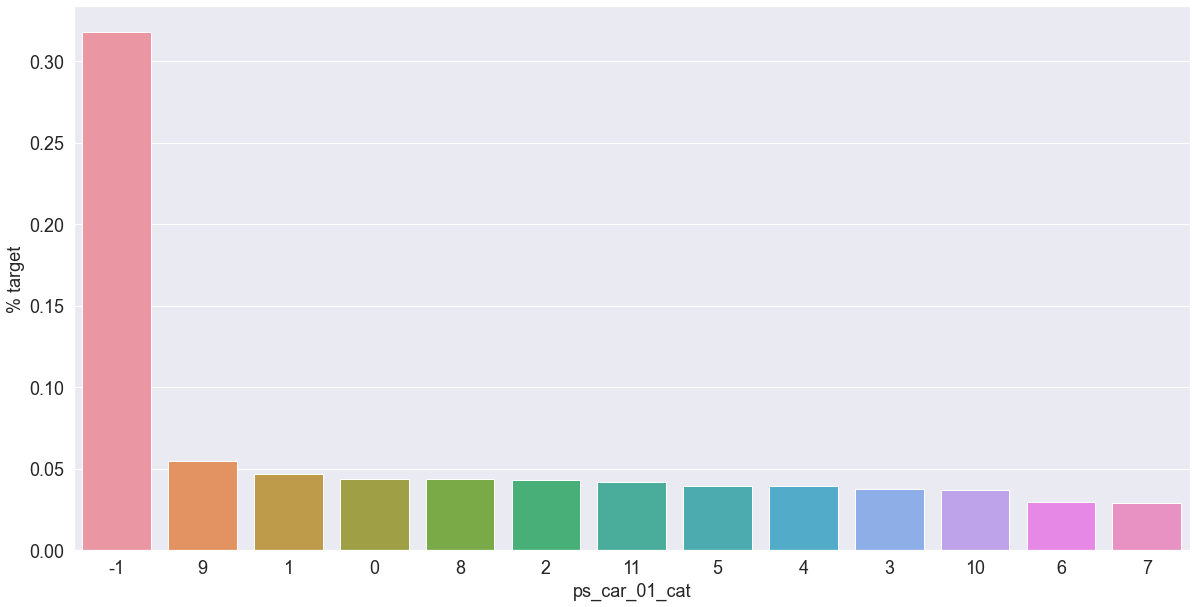

<Figure size 432x288 with 0 Axes>

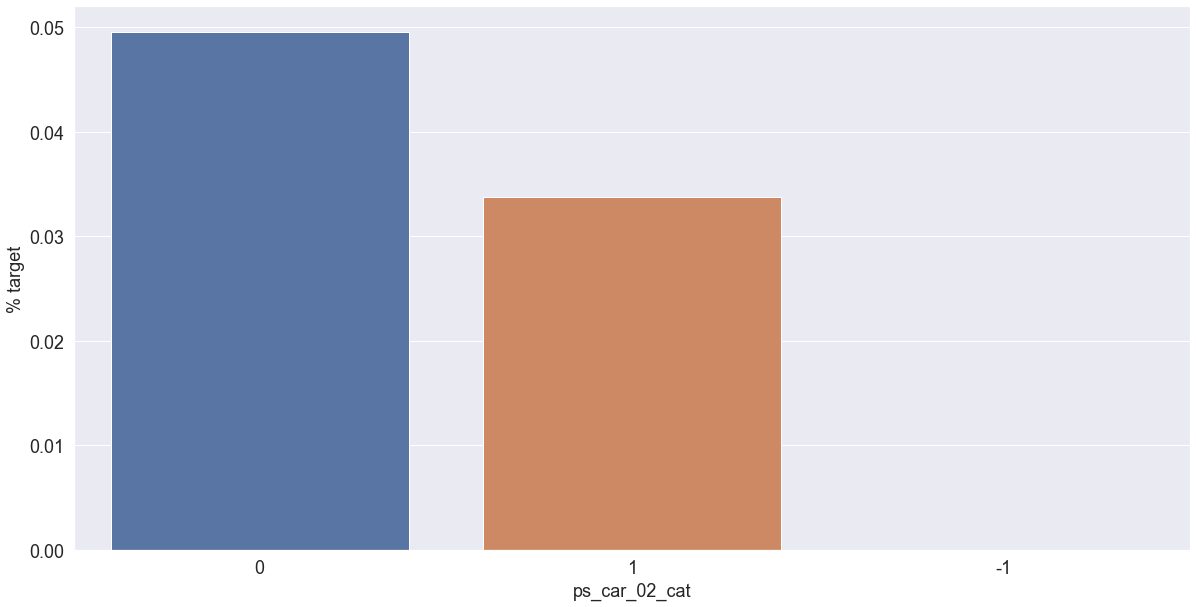

<Figure size 432x288 with 0 Axes>

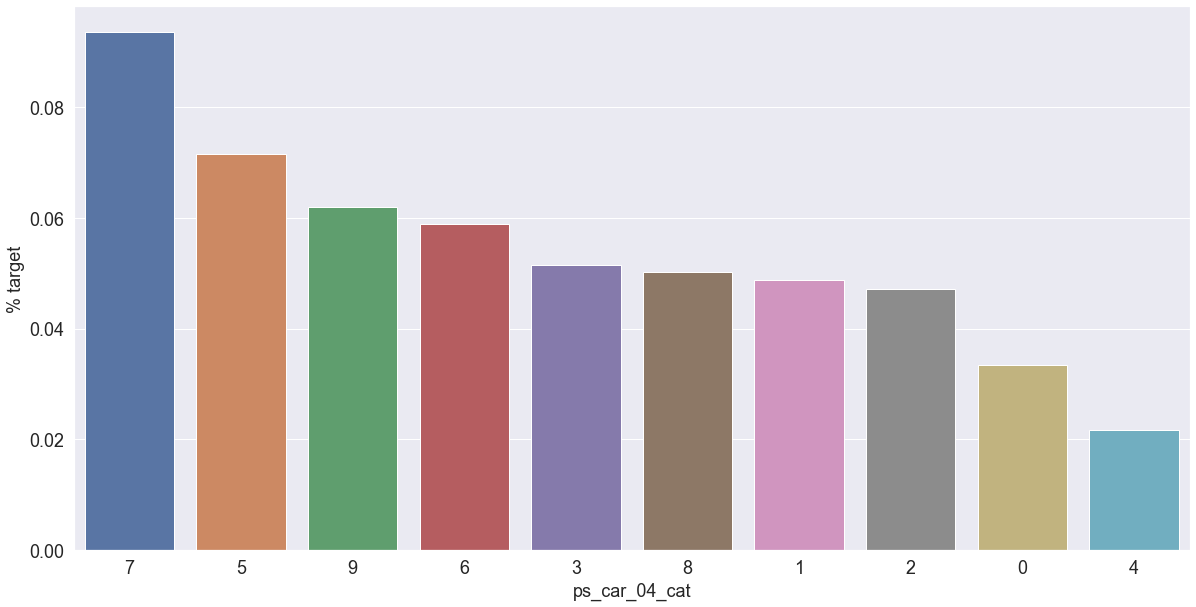

<Figure size 432x288 with 0 Axes>

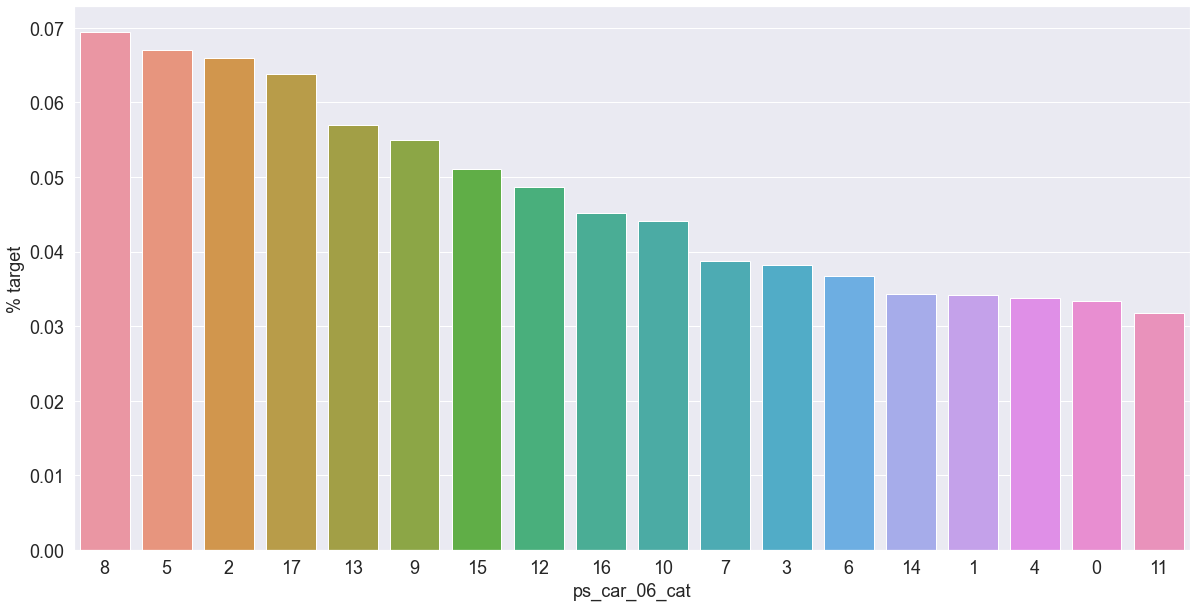

<Figure size 432x288 with 0 Axes>

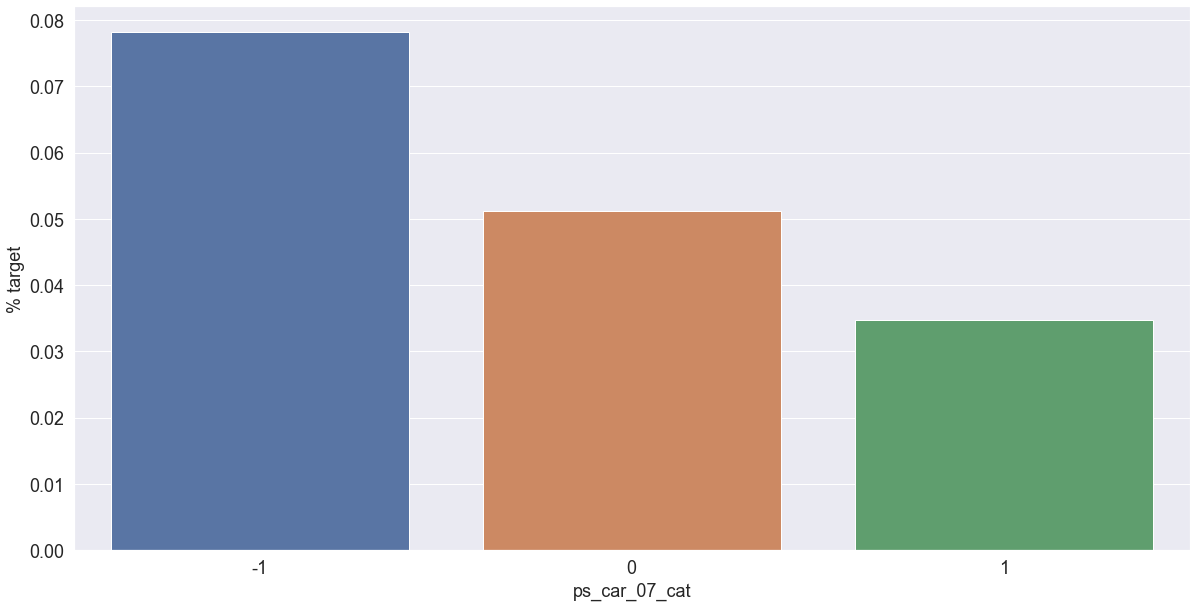

<Figure size 432x288 with 0 Axes>

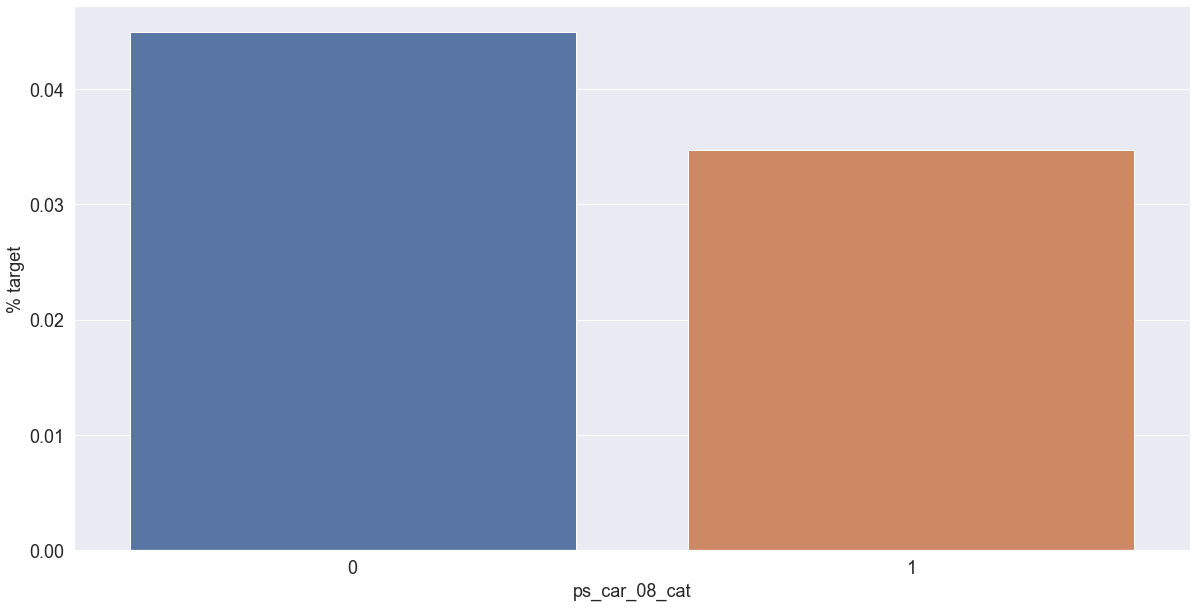

<Figure size 432x288 with 0 Axes>

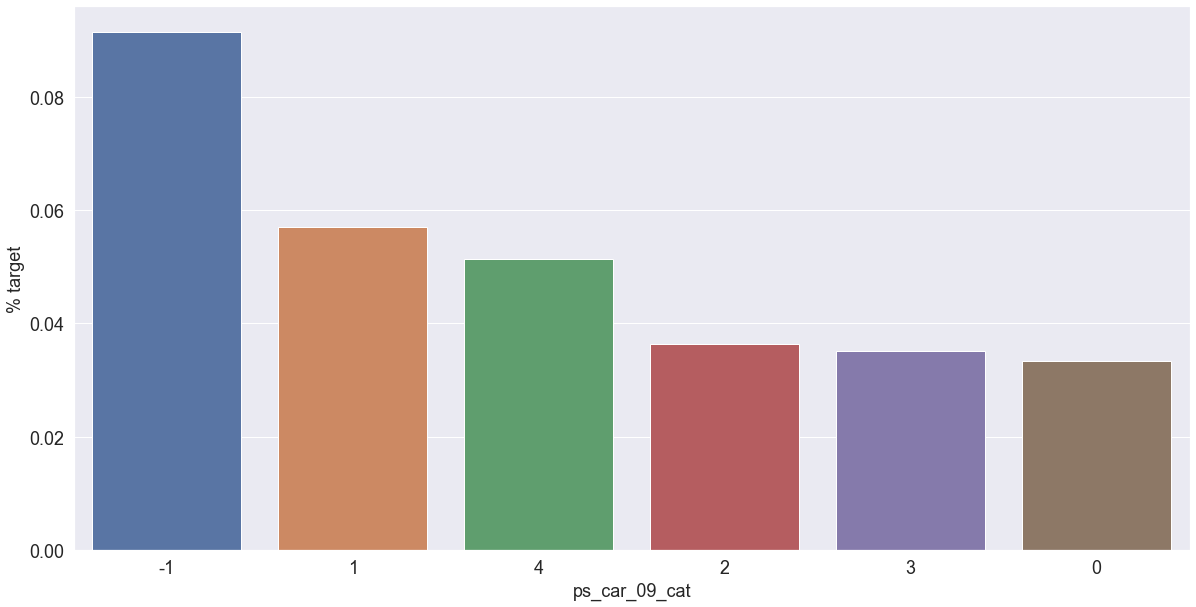

<Figure size 432x288 with 0 Axes>

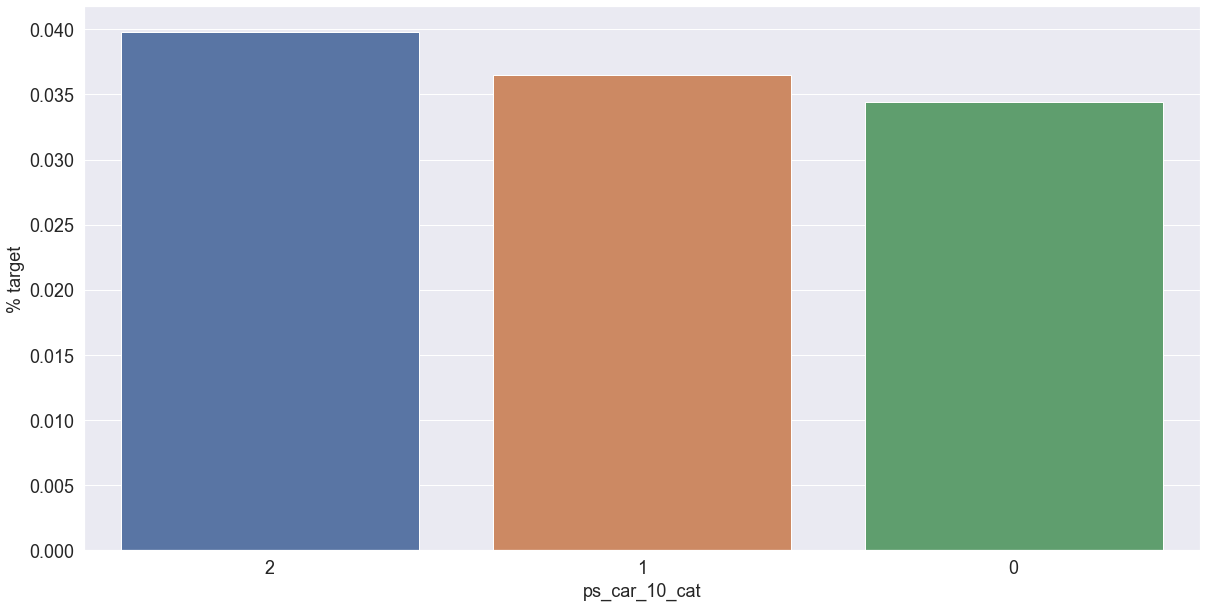

In [27]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # 범주형 값 당 타겟값이 1인 퍼센트를 계산
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar 플롯
    # 타겟 평균으로 내림차순
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    #sns.catplot(ax=ax, x=f, y='target', data=cat_perc, kind="bar", order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

**4-2. continous 데이터 seaborn heatmap 그려보기**

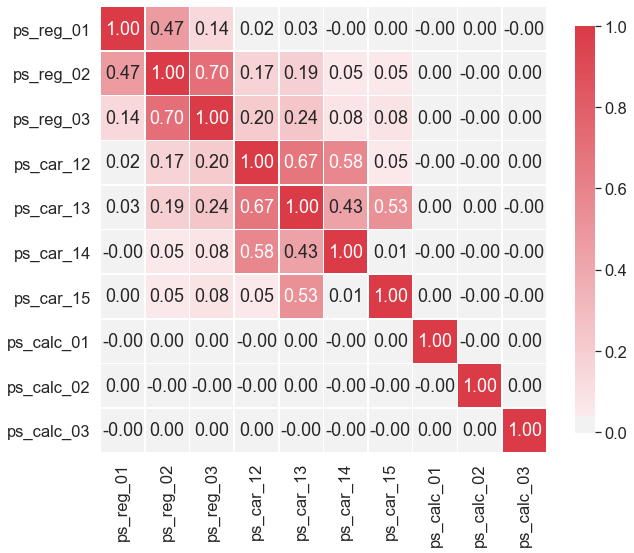

In [28]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # 두 가지 색상 사이의 색상 맵 만들기
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

In [29]:
s = train.sample(frac=0.1)

**4-3. 상관계수가 0.5이상인 변수들만 개별적으로 seaborn lmplot 그려보기( hue=’target’)**

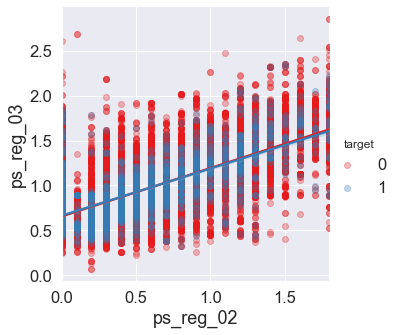

In [30]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

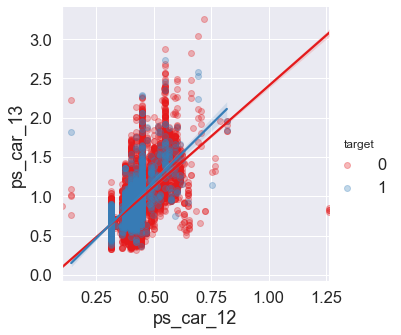

In [31]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

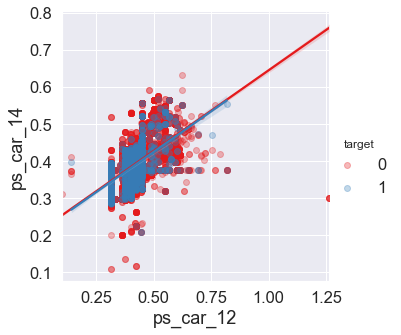

In [32]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

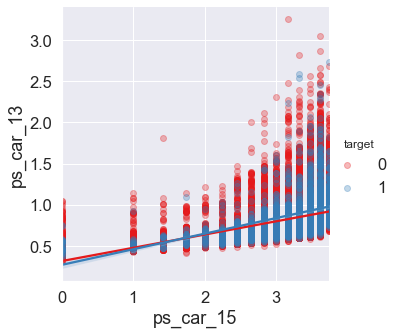

In [33]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

# 5. 피처엔지니어링

**5-1. nominal data 원핫인코딩**

In [13]:
#dummy variable
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train


In [14]:
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

After dummification we have 109 variables in train


In [15]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in test'.format(test.shape[1]))

Before dummification we have 56 variables in test


In [16]:
test = pd.get_dummies(test, columns=v, drop_first=True)
print('After dummification we have {} variables in test'.format(test.shape[1]))

After dummification we have 108 variables in test


**5-2. interaction 변수 만들기**

In [17]:
#interaction 변수 만들기
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # 원래의 컬럼 제거
# train 데이터에 상호 작용 변수 연결
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


In [18]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(test[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # 원래의 컬럼 제거
# train 데이터에 상호 작용 변수 연결
print('Before creating interactions we have {} variables in train'.format(test.shape[1]))
test = pd.concat([test, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(test.shape[1]))

Before creating interactions we have 108 variables in train
After creating interactions we have 163 variables in train


In [34]:
print(pd.isnull(test).sum())

id                       0
ps_ind_01                0
ps_ind_03                0
ps_ind_06_bin            0
ps_ind_07_bin            0
                        ..
ps_calc_01 ps_calc_02    0
ps_calc_01 ps_calc_03    0
ps_calc_02^2             0
ps_calc_02 ps_calc_03    0
ps_calc_03^2             0
Length: 163, dtype: int64


**5-3. undersampling**

In [74]:
#undersampling

desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train_under = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [93]:
# Class count
count_class_0, count_class_1 = train.target.value_counts()

# Divide by class
df_class_0 = train[train['target'] == 0]
df_class_1 = train[train['target'] == 1]

**5-4. Random under-sampling**

Random under-sampling:
1    21694
0    21694
Name: target, dtype: int64


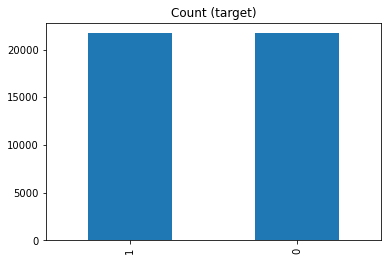

In [128]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

**5-5. Random over-sampling**

Random over-sampling:
1    573518
0    573518
Name: target, dtype: int64


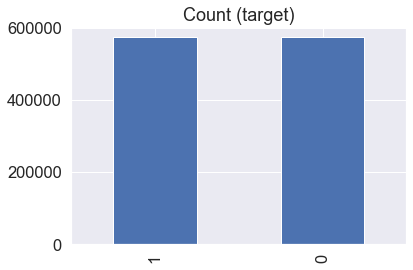

In [38]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

**5-6. randomforest의 feature_importance를 통해 중요도에 따라 변수 제거보기**

In [129]:
X_train_under = df_test_under.drop(['id', 'target'], axis=1)
y_train_under = df_test_under['target']

feat_labels = X_train_under.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train_under, y_train_under)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train_under.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.022237
 2) ps_car_12 ps_car_13            0.017942
 3) ps_car_13                      0.017925
 4) ps_car_13 ps_car_15            0.017865
 5) ps_car_13^2                    0.017797
 6) ps_reg_03 ps_car_13            0.017593
 7) ps_car_13 ps_car_14            0.017415
 8) ps_reg_01 ps_car_13            0.016744
 9) ps_reg_03 ps_car_14            0.016076
10) ps_reg_03 ps_car_12            0.015282
11) ps_car_14 ps_car_15            0.015222
12) ps_reg_03 ps_car_15            0.015198
13) ps_reg_02 ps_car_13            0.015034
14) ps_reg_01 ps_reg_03            0.014790
15) ps_reg_01 ps_car_14            0.014420
16) ps_car_13 ps_calc_01           0.014276
17) ps_car_13 ps_calc_02           0.014191
18) ps_car_13 ps_calc_03           0.014181
19) ps_reg_03                      0.013748
20) ps_car_14 ps_calc_02           0.013711
21) ps_reg_03^2                    0.013621
22) ps_car_14 ps_calc_03           0.013614
23) ps_car_12 ps_car_14         

In [130]:
sfm = SelectFromModel(rf, threshold='0.2*median', prefit=True)
print('Number of features before selection: {}'.format(X_train_under.shape[1]))
n_features = sfm.transform(X_train_under).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of features after selection: 162


In [131]:
df_test_under = df_test_under[selected_vars + ['target']]

In [132]:
test_under = test[selected_vars]

In [92]:
df_test_under

,ps_ind_01,ps_ind_03,ps_ind_15,ps_ind_17_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_car_11_cat_te,ps_ind_05_cat_0,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2,target
0,2,5,11,1,0.7,0.2,0.718070,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0.038657,1,0.14,0.502649,0.280000,0.618575,0.259567,2.523886,0.42,0.35,0.14,0.04,0.143614,0.080000,0.176736,0.074162,0.721110,0.12,0.10,0.04,0.515625,0.287228,0.634544,0.266268,2.589039,0.430842,0.359035,0.143614,0.1600,0.353472,0.148324,1.442221,0.240000,0.200000,0.080000,0.780888,0.327677,3.186150,0.530207,0.441839,0.176736,0.1375,1.336974,0.222486,0.185405,0.074162,13.0,2.163331,1.802776,0.721110,0.36,0.30,0.12,0.25,0.10,0.04,0
1,1,7,3,0,0.8,0.4,0.766078,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0.023729,1,0.32,0.612862,0.252982,0.495053,0.310973,1.959592,0.24,0.08,0.24,0.16,0.306431,0.126491,0.247527,0.155486,0.979796,0.12,0.04,0.12,0.586875,0.242255,0.474062,0.297787,1.876499,0.229823,0.076608,0.229823,0.1000,0.195687,0.122923,0.774597,0.094868,0.031623,0.094868,0.382934,0.240544,1.515785,0.185645,0.061882,0.185645,0.1511,0.952155,0.116615,0.038872,0.116615,6.0,0.734847,0.244949,0.734847,0.09,0.03,0.09,0.01,0.03,0.09,0
2,5,9,12,0,0.0,0.0,0.894047,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0.031134,1,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.799321,0.282723,0.573608,0.310480,2.965220,0.447024,0.625833,0.089405,0.1000,0.202887,0.109818,1.048809,0.158114,0.221359,0.031623,0.411632,0.222807,2.127899,0.320793,0.449110,0.064159,0.1206,1.151781,0.173638,0.243093,0.034728,11.0,1.658312,2.321637,0.331662,0.25,0.35,0.05,0.49,0.07,0.01,0
3,0,2,8,0,0.9,0.2,0.580948,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0.045599,1,0.18,0.522853,0.336749,0.488654,0.265462,1.800000,0.54,0.81,0.09,0.04,0.116190,0.074833,0.108590,0.058992,0.400000,0.12,0.18,0.02,0.337500,0.217371,0.315425,0.171355,1.161895,0.348569,0.522853,0.058095,0.1400,0.203153,0.110363,0.748331,0.224499,0.336749,0.037417,0.294793,0.160147,1.085898,0.325769,0.488654,0.054295,0.0870,0.589915,0.176975,0.265462,0.029496,4.0,1.200000,1.800000,0.200000,0.36,0.54,0.06,0.81,0.09,0.01,0
4,0,0,9,0,0.7,0.6,0.840759,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0.026212,1,0.42,0.588531,0.221249,0.396082,0.255572,1.400000,0.28,0.42,0.00,0.36,0.504455,0.189642,0.339499,0.219062,1.200000,0.24,0.36,0.00,0.706875,0.265738,0.475728,0.306963,1.681517,0.336303,0.504455,0.000000,0.0999,0.178842,0.115398,0.632139,0.126428,0.189642,0.000000,0.320165,0.206587,1.131663,0.226333,0.339499,0.000000,0.1333,0.730205,0.146041,0.219062,0.000000,4.0,0.800000,1.200000,0.000000,0.16,0.24,0.00,0.36,0.

In [93]:
test_under

,ps_ind_01,ps_ind_03,ps_ind_15,ps_ind_17_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_car_11_cat_te,ps_ind_05_cat_0,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,0,8,12,0,0.5,0.3,0.610328,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0.030794,1,0.15,0.305164,0.158114,0.334778,0.176068,1.732051,0.05,0.40,0.30,0.09,0.183098,0.094868,0.200867,0.105641,1.039230,0.03,0.24,0.18,0.372500,0.193003,0.408649,0.214919,2.114237,0.061033,0.488262,0.366197,0.10,0.211732,0.111355,1.095445,0.031623,0.252982,0.189737,0.448306,0.235775,2.319411,0.066956,0.535645,0.401734,0.1240,1.219836,0.035214,0.281709,0.211282,12.0,0.346410,2.771281,2.078461,0.01,0.08,0.06,0.64,0.48,0.36
1,4,5,5,0,0.9,0.5,0.771362,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0.026437,1,0.45,0.694226,0.284605,0.545688,0.322497,2.545584,0.36,0.45,0.36,0.25,0.385681,0.158114,0.303160,0.179165,1.414214,0.20,0.25,0.20,0.595000,0.243926,0.467692,0.276402,2.181742,0.308545,0.385681,0.308545,0.10,0.191735,0.113314,0.894427,0.126491,0.158114,0.126491,0.367624,0.217262,1.714932,0.242528,0.303160,0.242528,0.1284,1.013509,0.143332,0.179165,0.143332,8.0,1.131371,1.414214,1.131371,0.16,0.20,0.16,0.25,0.20,0.16
2,5,3,10,0,0.4,0.0,0.916174,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0.036007,1,0.00,0.366470,0.160000,0.358495,0.159399,1.326650,0.24,0.24,0.24,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.839375,0.366470,0.821111,0.365093,3.038606,0.549704,0.549704,0.549704,0.16,0.358495,0.159399,1.326650,0.240000,0.240000,0.240000,0.803244,0.357149,2.972487,0.537743,0.537743,0.537743,0.1588,1.321666,0.239098,0.239098,0.239098,11.0,1.989975,1.989975,1.989975,0.36,0.36,0.36,0.36,0.36,0.36
3,0,6,4,0,0.1,0.2,0.894895,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,0.034759,1,0.02,0.089490,0.037417,0.065211,0.038144,0.244949,0.01,0.05,0.05,0.04,0.178979,0.074833,0.130422,0.076289,0.489898,0.02,0.10,0.10,0.800837,0.334839,0.583570,0.341353,2.192036,0.089490,0.447448,0.447448,0.14,0.243997,0.142724,0.916515,0.037417,0.187083,0.187083,0.425248,0.248744,1.597338,0.065211,0.326055,0.326055,0.1455,0.934345,0.038144,0.190722,0.190722,6.0,0.244949,1.224745,1.224745,0.01,0.05,0.05,0.25,0.25,0.25
4,5,7,4,0,0.9,0.4,0.817771,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0.038543,1,0.36,0.735994,0.336749,0.731623,0.346588,2.984962,0.81,0.54,0.72,0.16,0.327109,0.149666,0.325166,0.154039,1.326650,0.36,0.24,0.32,0.668750,0.305982,0.664778,0.314922,2.712241,0.735994,0.490663,0.654217,0.14,0.304165,0.144090,1.240967,0.336749,0.224499,0.299333,0.660830,0.313051,2.696132,0.731623,0.487749,0.650331,0.1483,1.277224,0.346588,0.231058,0.308078,11.0,2.984962,1.989975,2.653300,0.81,0.54,0.72,0.36,0.48,0.64
...,...,...,

**5-7. 변수 정규화 진행**

In [133]:
scaler = StandardScaler()
X_train_under = scaler.fit_transform(df_test_under.drop(['target'], axis=1))
X_train_under = pd.DataFrame(X_train_under, columns=selected_vars)

In [134]:
test_under = scaler.fit_transform(test_under)
test_under = pd.DataFrame(test_under, columns=selected_vars)

In [96]:
test_under

,ps_ind_01,ps_ind_03,ps_ind_15,ps_ind_17_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_car_11_cat_te,ps_ind_05_cat_0,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,-0.957649,1.328174,1.327840,-0.369971,-0.386017,-0.345627,-9.090889e-01,-1.091526,-0.640988,-0.512564,0.542901,-1.217326,1.216353,0.521998,-1.227796,-0.778815,-1.265676,-0.006739,-2.208643,-0.271134,0.191591,-1.904861,-0.366699,-1.106809,1.624118,-0.601913,0.357971,-0.484054,-0.675001,-0.637454,-0.579928,-0.474514,-0.142005,-0.963879,0.533577,0.108017,-0.445759,-0.475890,-0.451443,-0.423760,-0.383891,-0.242928,-0.670606,0.166831,-0.071558,-0.760707,-1.036167,-0.842918,-0.943785,-0.533399,-1.113576,0.277243,-0.119269,-0.977734,-0.774196,-0.894648,-0.215572,-1.226762,0.720639,0.165001,-0.569490,-0.645853,-0.247975,-1.137852,0.643668,0.134784,-0.531155,0.229092,-1.209605,1.025215,0.387289,0.601029,-1.072642,1.440870,0.723372,-1.023041,-0.610536,-0.709830,1.318660,1.381488,0.279027
1,1.055941,0.217124,-0.648475,-0.369971,1.004326,0.148594,-3.946418e-01,-1.091526,-0.922315,-0.371705,-0.329076,-0.172805,0.172414,-0.174250,0.562790,0.980567,0.234114,0.699897,0.530034,-0.271134,-0.496555,-1.475691,-1.199602,0.073779,0.895754,-1.065775,0.357971,0.353155,0.359638,0.447544,0.165936,0.840355,0.663770,0.366278,0.747698,0.365436,-0.178885,-0.154077,-0.076884,-0.175540,0.085842,0.035788,0.009105,0.206742,0.008299,-0.439122,-0.686048,-0.694922,-0.465912,-0.478065,-0.305972,-0.056974,-0.307161,-0.977734,-0.919905,-0.840712,-0.813214,-0.390724,-0.114927,-0.392161,-0.743386,-0.808830,-0.816536,-0.469466,-0.241214,-0.470619,-0.403532,-0.446567,-0.228178,0.094413,-0.229572,-0.569464,-0.257873,0.033237,-0.259360,-0.464328,-0.012330,-0.211206,-0.132015,-0.013503,-0.465674
2,1.559339,-0.523576,0.763179,-0.369971,-0.733603,-1.086959,6.797888e-02,0.343296,0.367482,0.541882,0.340602,0.523542,0.520394,0.521998,-0.332503,0.980567,-0.515781,0.699897,-2.208643,0.529763,1.223810,-0.617351,-1.199602,-0.516515,-1.289338,-0.046844,0.357971,-0.902659,-0.511969,-0.621276,-0.496054,-0.624198,-0.543540,-0.148621,-0.151612,-0.149401,-0.595875,-0.766750,-1.013281,-0.911176,-1.058815,-1.015363,-0.790555,-0.791021,-0.790268,-0.085920,0.156486,0.190938,0.223430,0.224308,0.480904,0.477426,0.478796,0.250167,0.295191,0.428507,0.471818,0.609586,0.606296,0.607796,0.195519,0.422657,0.366295,0.654389,0.651654,0.651980,0.478227,0.562553,0.641128,0.638434,0.639812,0.308406,0.633336,0.630452,0.631556,0.280622,0.785278,0.786044,0.277150,0.783635,0.279027
3,-0.957649,0.587474,-0.930805,-0.369971,-1.776360,-0.592738,-1.064028e-15,-0.099184,-0.718602,0.154033,-0.848877,-1.217326,0.172414,0.173874,-0.332503,-0.778815,-0.515781,-0.006739,1.899372,-1.072031,1.567884,-0.188181,-0.366699,-1.697104,-0.925156,-0.179678,0.357971,-0.846845,-1.248546,-1.672754,-1.533229,-1.7130

In [97]:
X_train_under

,ps_ind_01,ps_ind_03,ps_ind_15,ps_ind_17_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_car_11_cat_te,ps_ind_05_cat_0,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,0.004597,0.190082,1.092388,2.370592,0.256572,-0.645807,-0.614987,0.236391,0.163932,-0.110813,0.706877,0.519470,0.172589,-0.877042,0.561466,-0.781192,1.734188,-1.412741,0.532879,-1.076784,-1.185454,1.517691,-0.365006,1.255218,0.163649,0.106288,0.408216,-0.567470,-0.226248,0.324237,0.298558,0.217089,0.565839,0.585160,0.288119,-0.607432,-0.565515,-0.579960,-0.594622,-0.538094,-0.637381,-0.543748,-0.353786,-0.430900,-0.656474,-0.590532,-0.459469,-0.363209,-0.595065,-0.231172,0.053416,-0.173043,-0.858382,0.146043,0.117625,0.045578,0.711522,0.572419,0.228832,-0.815693,0.017289,0.043604,0.424044,0.541946,0.226539,-0.743318,-0.162764,0.551668,0.479645,0.145481,-0.864836,0.852087,0.785257,0.413573,-0.709291,0.276852,0.484560,-0.415721,-0.130385,-0.515890,-0.915930
1,-0.491996,0.918643,-1.156017,-0.421836,0.609518,-0.174802,-0.467507,-1.135468,-0.914720,0.277916,-0.962908,-0.525921,-1.225808,-0.528196,-0.333331,-0.781192,0.983592,1.406810,-0.835077,-1.076784,-0.496622,-1.044972,-0.365006,-1.104285,0.527353,-1.420548,0.408216,-0.089364,0.059124,0.093608,-0.119966,0.683048,0.003051,-0.181304,-0.863579,-0.182088,-0.379692,-0.337397,-0.336967,-0.381448,-0.143255,-0.361355,-0.353786,-0.659726,-0.354798,-0.493481,-0.750257,-0.728842,-0.360694,-0.801263,-0.583934,-1.070941,-0.585391,-1.005280,-0.919035,-0.615455,-1.281150,-0.684786,-1.235496,-0.686838,-0.728342,-0.650745,-1.073331,-0.705956,-1.159346,-0.710886,0.210315,-0.735130,-0.478221,-1.182857,-0.480494,-1.270348,-0.692724,-1.200861,-0.695084,-0.729041,-0.864545,-0.565540,-1.027288,-0.864518,-0.729725
2,1.494375,1.647205,1.373438,-0.421836,-2.214055,-1.116812,-0.074380,-1.135468,-0.821993,-0.621743,0.289559,0.171007,0.871787,-1.225888,-0.333331,0.098231,0.983592,-1.412741,-0.835077,-0.274179,-0.496622,-0.617862,0.467150,2.434970,-0.200055,-0.663139,0.408216,-0.939330,-1.527743,-2.065888,-1.797332,-2.135714,-1.951310,-1.203255,-1.204822,-1.202915,-0.627456,-0.793914,-1.037984,-0.929177,-1.087990,-1.052185,-0.806307,-0.812276,-0.807312,-0.204103,-0.488601,-0.502041,-0.266303,0.069803,0.104721,0.675166,-1.030043,-1.005280,-0.871729,-0.956487,-0.462703,-0.136920,0.414589,-1.234951,-0.674571,-0.792089,-0.524609,-0.216491,0.253058,-1.153142,-0.626371,-0.067600,0.037691,0.668425,-1.221853,0.245677,0.262739,0.951289,-1.112057,-0.132956,0.734394,-0.765298,0.766517,-0.665302,-1.027653
3,-0.988588,-0.902761,0.249236,-0.421836,0.962465,-0.645807,-1.036233,-0.186672,-1.223692,-1.757531,-1.612140,0.519470,1.570986,-1.225888,-0.333331,1.857077,-0.517602,-1.412741,-0.835077,1.331032,-2.218703,-1.472082,0.467150,0.665342,0.527353,0.816335,0.408216,-0.461224,-0.173935,0.808657,-0.141649,0.2

# 6. 모델링

**6-1. gini metric + XGBoost 모델 적용**

In [142]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [143]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=1,shuffle=True)
np.random.seed(0)

In [144]:
params = {
    'min_child_weight': 6,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'learning_rate': 0.07,
    'scale_pos_weight' :1.6,
    'gamma': 10,
    'reg_alpha' : 8,
    'reg_lambda' : 1.3
    }

In [145]:
test_id = test.id.values

In [146]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [147]:
import xgboost as xgb

In [148]:
for i, (train_index, test_index) in enumerate(skf.split(X_train_under, y_train_under)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X_train_under.iloc[train_index], X_train_under.iloc[test_index]
    y_train, y_valid = y_train_under.iloc[train_index], y_train_under.iloc[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test_under)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold

[Fold 1/5]
[0]	train-error:0.47436	valid-error:0.47350	train-gini:0.10368	valid-gini:0.08432
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.42965	valid-error:0.44054	train-gini:0.32551	valid-gini:0.26897
[200]	train-error:0.42221	valid-error:0.43662	train-gini:0.34326	valid-gini:0.26936
Stopping. Best iteration:
[143]	train-error:0.42529	valid-error:0.43812	train-gini:0.33518	valid-gini:0.26985

[Fold 1/5 Prediciton:]
[Fold 2/5]
[0]	train-error:0.46390	valid-error:0.46197	train-gini:0.09233	valid-gini:0.08120
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.43175	valid-error:0.43616	train-gini:0.31987	valid-gini:0.27790
[200]	train-error:0.42457	valid-error:0.43362	train-gini:0.34043	valid-gini:0.27904
Stopping. Best iteration:
[191]	train-error:0.42535	va

In [149]:
sub.to_csv('./under_xgb_162.csv', index=False)

**6-2. 앙상블**

In [47]:
from sklearn.linear_model import LogisticRegression

In [135]:
id_test = test['id'].values

In [136]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [137]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

In [138]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

In [139]:
stack = Ensemble(n_splits=5,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))  

In [140]:
y_prediction = stack.fit_predict(X_train_under, y_train_under, test_under)

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63185 [gini]: 0.26370
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63058 [gini]: 0.26116
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.62889 [gini]: 0.25778
Base model 1: fit LGBMClassifier model | fold 4
cross_score [roc-auc]: 0.63058 [gini]: 0.26117
Base model 1: fit LGBMClassifier model | fold 5
cross_score [roc-auc]: 0.63261 [gini]: 0.26523
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63451 [gini]: 0.26901
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63189 [gini]: 0.26377
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63087 [gini]: 0.26175
Base model 2: fit LGBMClassifier model | fold 4
cross_score [roc-auc]: 0.63092 [gini]: 0.26183
Base model 2: fit LGBMClassifier model | fold 5
cross_score [roc-auc]: 0.63273 [gini]: 0.26545
Base model 3: fit LGBMClassifier model | fold 1
cr

[14:28:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_threads } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:28:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_threads } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:28:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_threads } might not be used.

  This may not be accurate due to some parameters are only used in langu

In [141]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('./under_stacked_5_162.csv', index=False)